In [2]:
import os
from os.path import join as pj

import matplotlib.pyplot as plt
import pandas as pd

from sae_cooccurrence.normalised_cooc_functions import neat_sae_id
from sae_cooccurrence.utils.saving_loading import set_device
from sae_cooccurrence.utils.set_paths import get_git_root

In [3]:
# Setup
device = set_device()
git_root = get_git_root()

# Configuration
gpt_model_name = "gpt2-small"
gpt_sae_release_short = "res-jb-feature-splitting"
gpt_sae_ids = [
    "blocks.8.hook_resid_pre_768",
    "blocks.8.hook_resid_pre_1536",
    "blocks.8.hook_resid_pre_3072",
    "blocks.8.hook_resid_pre_6144",
    "blocks.8.hook_resid_pre_12288",
    "blocks.8.hook_resid_pre_24576",
    "blocks.8.hook_resid_pre_49152",
    "blocks.8.hook_resid_pre_98304",
]

gpt_n_batches_generation = 500

gemma_width_model_name = "gemma-2-2b"
gemma_width_sae_release_short = "gemma-scope-2b-pt-res-canonical"
gemma_width_sae_ids = [
    "layer_12/width_16k/canonical",
    "layer_12/width_32k/canonical",
    "layer_12/width_65k/canonical",
    # "layer_12/width_262k/canonical",
    # "layer_12/width_524k/canonical",
    # "layer_12/width_1m/canonical",
]

gemma_width_n_batches_generation = 100

gemma_l0_model_name = "gemma-2-2b"
gemma_l0_sae_release_short = "gemma-scope-2b-pt-res"
gemma_l0_sae_ids = [
    "layer_12/width_16k/average_l0_22",
    "layer_12/width_16k/average_l0_41",
    "layer_12/width_16k/average_l0_82",
    "layer_12/width_16k/average_l0_176",
    "layer_12/width_16k/average_l0_445",
]

gemma_l0_n_batches_generation = 100

n_batches = 10
activation_threshold = 1.5  # You can adjust this threshold
activation_threshold_safe = str(activation_threshold).replace(".", "_")

Using MPS


In [4]:
def load_node_info_df(
    model_name, sae_release_short, sae_id, activation_threshold_safe, n_batches
):
    base_path = pj(
        get_git_root(),
        "results",
        model_name,
        sae_release_short,
    )
    sae_id_neat = neat_sae_id(sae_id)
    file_path = pj(
        base_path,
        sae_id_neat,
        f"n_batches_{n_batches}",
        "dataframes",
        f"node_info_df_{activation_threshold_safe}.csv",
    )
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        return df
    else:
        print(f"Warning: File not found - {file_path}")
        return None


# Load node_info_df for GPT-2
gpt_node_info_dfs = {}
for sae_id in gpt_sae_ids:
    df = load_node_info_df(
        gpt_model_name,
        gpt_sae_release_short,
        sae_id,
        activation_threshold_safe,
        gpt_n_batches_generation,
    )
    if df is not None:
        gpt_node_info_dfs[sae_id] = df

# Load node_info_df for Gemma (width comparison)
gemma_width_node_info_dfs = {}
for sae_id in gemma_width_sae_ids:
    df = load_node_info_df(
        gemma_width_model_name,
        gemma_width_sae_release_short,
        sae_id,
        activation_threshold_safe,
        gemma_width_n_batches_generation,
    )
    if df is not None:
        gemma_width_node_info_dfs[sae_id] = df

# Load node_info_df for Gemma (L0 comparison)
gemma_l0_node_info_dfs = {}
for sae_id in gemma_l0_sae_ids:
    df = load_node_info_df(
        gemma_l0_model_name,
        gemma_l0_sae_release_short,
        sae_id,
        activation_threshold_safe,
        gemma_l0_n_batches_generation,
    )
    if df is not None:
        gemma_l0_node_info_dfs[sae_id] = df

# Print summary of loaded dataframes
print(f"Loaded {len(gpt_node_info_dfs)} node_info_dfs for GPT-2")
print(
    f"Loaded {len(gemma_width_node_info_dfs)} node_info_dfs for Gemma (width comparison)"
)
print(f"Loaded {len(gemma_l0_node_info_dfs)} node_info_dfs for Gemma (L0 comparison)")

Loaded 8 node_info_dfs for GPT-2
Loaded 3 node_info_dfs for Gemma (width comparison)
Loaded 5 node_info_dfs for Gemma (L0 comparison)


In [5]:
# Create output directories
gpt_output_dir = pj(
    git_root,
    "results",
    "size_effects",
    gpt_model_name,
    gpt_sae_release_short,
    f"l0_comparison_{activation_threshold_safe}",
)
gemma_width_output_dir = pj(
    git_root,
    "results",
    "size_effects",
    gemma_width_model_name,
    gemma_width_sae_release_short,
    f"l0_comparison_{activation_threshold_safe}",
)
gemma_l0_output_dir = pj(
    git_root,
    "results",
    "size_effects",
    gemma_l0_model_name,
    gemma_l0_sae_release_short,
    f"l0_comparison_{activation_threshold_safe}",
)

os.makedirs(gpt_output_dir, exist_ok=True)
os.makedirs(gemma_width_output_dir, exist_ok=True)
os.makedirs(gemma_l0_output_dir, exist_ok=True)

In [6]:
# Calculate means for GPT-2
gpt_sizes = []
gpt_means_with_ones = []
gpt_means_without_ones = []

for sae_id in gpt_sae_ids:
    df = gpt_node_info_dfs[sae_id]
    size = int(sae_id.split("_")[-1])  # Extract size from sae_id

    mean_with_ones = df["subgraph_size"].mean()
    mean_without_ones = df[df["subgraph_size"] > 1]["subgraph_size"].mean()

    gpt_sizes.append(size)
    gpt_means_with_ones.append(mean_with_ones)
    gpt_means_without_ones.append(mean_without_ones)

In [7]:
# Calculate means for Gemma (width comparison)
gemma_sizes = []
gemma_means_with_ones = []
gemma_means_without_ones = []

for sae_id in gemma_width_sae_ids:
    df = gemma_width_node_info_dfs[sae_id]
    size = int(sae_id.split("width_")[1].split("k")[0])  # Extract size from sae_id
    if "1m" in sae_id:
        size = 1024  # Convert 1m to 1024k for consistent scaling

    mean_with_ones = df["subgraph_size"].mean()
    mean_without_ones = df[df["subgraph_size"] > 1]["subgraph_size"].mean()

    gemma_sizes.append(size)
    gemma_means_with_ones.append(mean_with_ones)
    gemma_means_without_ones.append(mean_without_ones)

In [8]:
# Also save individual plots
# GPT-2
plt.figure(figsize=(6, 6))
plt.plot(gpt_sizes, gpt_means_with_ones, "o-", label="Including size 1", color="blue")
plt.plot(
    gpt_sizes,
    gpt_means_without_ones,
    "o--",
    label="Excluding size 1",
    color="blue",
    alpha=0.7,
)
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("SAE Size (number of features)")
plt.ylabel("Mean Subgraph Size")
plt.xticks(gpt_sizes, gpt_sizes)  # Set specific x-tick locations and labels
plt.title(
    f"GPT-2 Mean Subgraph Size vs. SAE Size (Activation Threshold = {activation_threshold})"
)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(
    pj(gpt_output_dir, "gpt2_mean_subgraph_size.png"), dpi=300, bbox_inches="tight"
)
plt.close()

# Gemma
plt.figure(figsize=(6, 6))
plt.plot(
    gemma_sizes, gemma_means_with_ones, "o-", label="Including size 1", color="red"
)
plt.plot(
    gemma_sizes,
    gemma_means_without_ones,
    "o--",
    label="Excluding size 1",
    color="red",
    alpha=0.7,
)
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("SAE Size (number of features)")
plt.ylabel("Mean Subgraph Size")
# plt.xticks(gemma_sizes, gemma_sizes)  # Set specific x-tick locations and labels
plt.title(
    f"Gemma Mean Subgraph Size vs. SAE Size (Activation Threshold = {activation_threshold})"
)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(
    pj(gemma_width_output_dir, "gemma_mean_subgraph_size.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.close()

In [9]:
# Calculate means for Gemma (L0 comparison)
gemma_l0_sizes = []
gemma_l0_means_with_ones = []
gemma_l0_means_without_ones = []

for sae_id in gemma_l0_sae_ids:
    df = gemma_l0_node_info_dfs[sae_id]
    size = int(sae_id.split("_")[-1])  # Extract L0 size from sae_id

    mean_with_ones = df["subgraph_size"].mean()
    mean_without_ones = df[df["subgraph_size"] > 1]["subgraph_size"].mean()

    gemma_l0_sizes.append(size)
    gemma_l0_means_with_ones.append(mean_with_ones)
    gemma_l0_means_without_ones.append(mean_without_ones)

# Plot for Gemma (L0 comparison)
plt.figure(figsize=(6, 6))
plt.plot(
    gemma_l0_sizes,
    gemma_l0_means_with_ones,
    "o-",
    label="Including size 1",
    color="green",
)
plt.plot(
    gemma_l0_sizes,
    gemma_l0_means_without_ones,
    "o--",
    label="Excluding size 1",
    color="green",
    alpha=0.7,
)
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("L0 Size (number of features)")
plt.ylabel("Mean Subgraph Size")
plt.title(
    f"Gemma L0 Mean Subgraph Size vs. L0 Size (Activation Threshold = {activation_threshold})"
)
plt.xticks(gemma_l0_sizes, gemma_l0_sizes)  # Set specific x-tick locations and labels
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(
    pj(gemma_l0_output_dir, "gemma_l0_mean_subgraph_size.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.close()

In [10]:
# For GPT-2
gpt_cluster_fractions = []
for sae_id in gpt_sae_ids:
    df = gpt_node_info_dfs[sae_id]
    total_features = len(df)
    features_in_clusters = len(df[df["subgraph_size"] > 1])
    gpt_cluster_fractions.append(features_in_clusters / total_features)

# For Gemma width comparison
gemma_cluster_fractions = []
for sae_id in gemma_width_sae_ids:
    df = gemma_width_node_info_dfs[sae_id]
    total_features = len(df)
    features_in_clusters = len(df[df["subgraph_size"] > 1])
    gemma_cluster_fractions.append(features_in_clusters / total_features)

# For Gemma L0 comparison
gemma_l0_cluster_fractions = []
for sae_id in gemma_l0_sae_ids:
    df = gemma_l0_node_info_dfs[sae_id]
    total_features = len(df)
    features_in_clusters = len(df[df["subgraph_size"] > 1])
    gemma_l0_cluster_fractions.append(features_in_clusters / total_features)

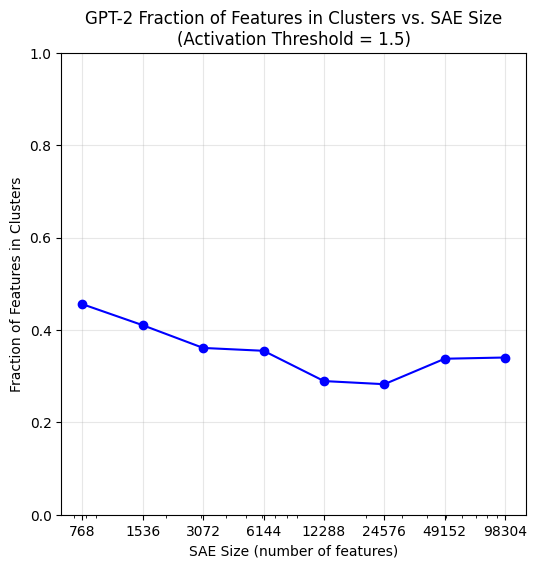

In [12]:
# Plot cluster fractions
# GPT-2
plt.figure(figsize=(6, 6))
plt.plot(gpt_sizes, gpt_cluster_fractions, "o-", color="blue")
plt.xscale("log")
plt.xlabel("SAE Size (number of features)")
plt.ylabel("Fraction of Features in Clusters")
plt.xticks(gpt_sizes, gpt_sizes)
plt.title(
    f"GPT-2 Fraction of Features in Clusters vs. SAE Size\n(Activation Threshold = {activation_threshold})"
)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.savefig(
    pj(gpt_output_dir, "gpt2_cluster_fractions.png"), dpi=300, bbox_inches="tight"
)
plt.show()

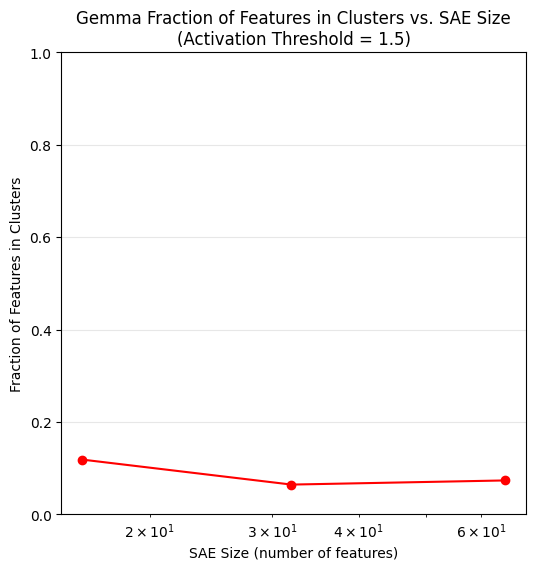

In [13]:
# Gemma width
plt.figure(figsize=(6, 6))
plt.plot(gemma_sizes, gemma_cluster_fractions, "o-", color="red")
plt.xscale("log")
plt.xlabel("SAE Size (number of features)")
plt.ylabel("Fraction of Features in Clusters")
plt.title(
    f"Gemma Fraction of Features in Clusters vs. SAE Size\n(Activation Threshold = {activation_threshold})"
)
plt.grid(True, alpha=0.3)
plt.savefig(
    pj(gemma_width_output_dir, "gemma_cluster_fractions.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.ylim(0, 1)
plt.show()

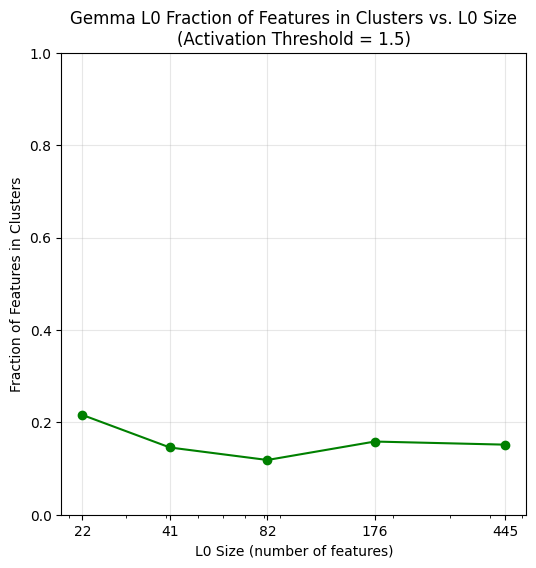

In [14]:
# Gemma L0
plt.figure(figsize=(6, 6))
plt.plot(gemma_l0_sizes, gemma_l0_cluster_fractions, "o-", color="green")
plt.xscale("log")
plt.xlabel("L0 Size (number of features)")
plt.ylabel("Fraction of Features in Clusters")
plt.xticks(gemma_l0_sizes, gemma_l0_sizes)
plt.title(
    f"Gemma L0 Fraction of Features in Clusters vs. L0 Size\n(Activation Threshold = {activation_threshold})"
)
plt.grid(True, alpha=0.3)
plt.savefig(
    pj(gemma_l0_output_dir, "gemma_l0_cluster_fractions.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.ylim(0, 1)
plt.show()